# Analyze the various annotations we have for clixo communities

Can we break them down to categories like in the autophagy paper? 
E.g:
- Well described, in GO
- Well described, not in GO
- New subprocess
- New superprocess (integrating known processes)
- Expanded process, new gene(s) added


Also add extra edge annotations for selected communities, from STRING

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random

import community

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'sans-serif')

sns.set_style('white')

from IPython.display import display

import sys
% matplotlib inline

In [2]:
# define where the supp tables are, so we can load relevant data
path_to_supp_tables = '../../../manuscript/tables_19_01/supplemental_tables.xlsx' 

# define where to find PCnet 
path_to_PCnet='/Users/brinrosenthal/Documents/CCBB_tickets_data/PCnet/G_PCnet.gpickle'


In [3]:
# Load the community classification results, make a pie chart of breakdown
# comm_class_df = pd.read_excel('../manuscript/tables_19_01/community_classification_manual.xlsx',index_col='Unnamed: 0')
comm_class_df = pd.read_excel(path_to_supp_tables,index_col='Unnamed: 0',
                             sheet_name='community_classification_with_a')
comm_class_df.head()

,Cytoscape_name,Categorization,Curated name,all_val_genes,cluster_size,num_DECIPHER_CNV,num_DECIPHER_SNV,num_shared_DNV,term.1,fractionVal,...,pathway,term_ID,Aligned_Term_BP,Aligned_Similarity_BP,Aligned_FDR_BP,Aligned_Term_Description_BP,Aligned_Term_CC,Aligned_Similarity_CC,Aligned_FDR_CC,Aligned_Term_Description_CC
910,910,"New subprocess, extended",Acetylation-related processes,5,29,4,4,1,910,0.172414,...,chromatin organization,GO:0006325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
888,888,"New subprocess, extended",actin binding,3,17,0,0,3,888,0.176471,...,actin binding,GO:0003779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
852,852,Aligned to GO,angiotensin-activated signaling pathway,4,9,2,2,2,852,0.444444,...,CREB phosphorylation through the activation of...,REAC:R-HSA-442729,GO:0038166,0.100314,0.0,angiotensin-activated signaling pathway,NaN,NaN,NaN,NaN
865,865,Aligned to GO,anterior/posterior axon guidance,2,12,2,0,0,865,0.166667,...,FLRT3-LPHN3-UNC5B complex,CORUM:6527,GO:0033564,0.118068,0.0,anterior/posterior axon guidance,NaN,NaN,NaN,NaN
890,890,"New subprocess, extended",axon development,2,17,2,0,0,890,0.117647,...,nervous system development,GO:0007399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
class_vc = comm_class_df['Categorization'].value_counts()
class_vc
# plt.pie()

Aligned to GO               30
New superprocess            30
New subprocess, extended    27
New process                 22
New subprocess               9
New superprocess, root       1
Well described               1
Name: Categorization, dtype: int64

(-1.1084255285860782,
 1.100401273011919,
 -1.1022290211438766,
 1.1102691352873637)

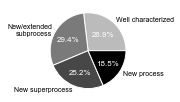

In [5]:
plt.figure(figsize=(1.5,1.5))
# fig1, ax1 = plt.subplots()
ax1=plt.gca()
patches, texts, autotexts=plt.pie([31+1,27+8,30,22],labels=['Well characterized','New/extended\nsubprocess','New superprocess','New process'],
       autopct='%1.1f%%',textprops={'fontsize': 8,'color':'white'},colors=['#BBBBBB','#7A7A7A','#474747','#000000'])
[t.set_fontsize(7) for t in texts]
[t.set_color('black') for t in texts]
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.savefig('../manuscript/figures_1911/Figure4/system_char_piechart.png',dpi=300,bbox_inches='tight')
# plt.savefig('../manuscript/figures_1911/Figure4/system_char_piechart.svg',dpi=300,bbox_inches='tight')
# plt.savefig('../manuscript/figures_1911/Figure4/system_char_piechart.pdf',dpi=300,bbox_inches='tight')


# Load gene to community results

In [10]:
gene2term= pd.read_csv('new_clixo_files/gene2term_full_01_45.csv',index_col='Unnamed: 0')
gene2term.head()

,844,845,846,847,848,849,850,851,852,853,...,954,955,956,957,958,959,960,961,962,963
AC008575.1,False,False,False,True,False,False,False,False,False,False,...,False,True,False,False,True,False,True,True,True,True
AC067968.1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
ACHE,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,True
ACTB,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,True,False,True,True
ACTN2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,True,False,True,True,False,True


# Load gprofiler results

This is where we manually examine each community. Loop over each community (focal_cluster), and evaluate some properties:

A system was classified as 1) well characterized if it aligned to the gene ontology, or had a precision and recall of > 40% with an annotated pathway in over-representation analysis, 2) a new subprocess if > 90% of the genes in the system overlap with significantly enriched pathways and the precision is < 40% (so most genes in the ASD-CHD system are contained in the known pathway, but the known pathway contains many genes missing from the ASD-CHD system), 3) an new and extended subprocess if <90% of the genes in the system overlap with significantly enriched pathways, and the precision is < 40% (so there is a lot of overlap between the ASD-CHD system and the known pathway, but some genes in the ASD-CHD system have not been connected to the known pathway, and the known pathway contains many genes missing from the ASD-CHD system), 4) a new super-process if multiple sets of known pathways are significantly enriched for the genes in the ASD-CHD system which do not overlap (so the genes in the ASD-CHD system unite two or more known pathways in a new way), or 5) a new process if there are no known pathways significantly enriched for the genes in the ASD-CHD system.  Known pathways from GO, KEGG and REACTOME were defined as significantly enriched if they had term sizes of < 500, to filter to less general biological functions, if they had at least 3 genes overlapping with the ASD-CHD system, and if they had an overlap p-value < 0.05 (after adjusting for multiple testing). Systems are labeled by manual curation of enriched pathways.


In [14]:
focal_cluster=951
genes_in_cluster = gene2term[gene2term[str(focal_cluster)]].index.tolist()
print(len(genes_in_cluster))
# gprofiler_df = pd.read_excel('gprofiler_ASD_CHD_cosine_alpha_01_beta_45/cluster_'+str(focal_cluster)+'.xlsx')
gprofiler_df = pd.read_excel('gprofiler_clixo_ASD_CHD_cosine_alpha_01_beta_45/cluster_'+str(focal_cluster)+'.xlsx',
                          index_col='Unnamed: 0')
# filter to kegg, reactome, GO only, term size < 500, >2, overlap size at least 2
print(len(gprofiler_df))
gprofiler_df = gprofiler_df[gprofiler_df['domain'].isin(['rea','keg','CC','BP','MF'])]
print(len(gprofiler_df))
gprofiler_df = gprofiler_df[gprofiler_df['term.size']<500]
print(len(gprofiler_df))
gprofiler_df = gprofiler_df[gprofiler_df['term.size']>2]
print(len(gprofiler_df))
gprofiler_df = gprofiler_df[gprofiler_df['overlap.size']>2] 
print(len(gprofiler_df))
# filter by bonferroni adjusted p-value for testing 120 terms
gprofiler_df = gprofiler_df[gprofiler_df['p.value']<(.05/120)]
print(len(gprofiler_df))

gprofiler_df = gprofiler_df.sort_values('p.value') # make sure they're sorted

# how many precision and recall > 0.4?
print('well described terms:')
num_well_described_terms = sum((gprofiler_df['recall']>=.4)*(gprofiler_df['precision']>=.4))
if num_well_described_terms>0:
    display(gprofiler_df[(gprofiler_df['recall']>=.4)*(gprofiler_df['precision']>=.4)])
else:
    print(0)

gprofiler_df.head(15)

110
2139
1368
960
847
671
203
well described terms:
0


/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


,query.number,significant,p.value,term.size,query.size,overlap.size,recall,precision,term.id,domain,subgraph.number,term.name,relative.depth,intersection
6,1,True,5.220000e-17,348,102,24,0.235,0.069,GO:0000790,CC,1,nuclear chromatin,1,"ARID1B,SMARCD1,ACTB,SMARCB1,CHD5,ARID1A,ASH2L,..."
9,1,True,1.210000e-16,274,75,23,0.307,0.084,REAC:R-HSA-3247509,rea,1,Chromatin modifying enzymes,1,"ARID1B,SMARCD1,ACTB,SMARCB1,KAT8,DOT1L,KANSL3,..."
10,1,True,1.210000e-16,274,75,23,0.307,0.084,REAC:R-HSA-4839726,rea,1,Chromatin organization,1,"ARID1B,SMARCD1,ACTB,SMARCB1,KAT8,DOT1L,KANSL3,..."
11,1,True,1.800000e-16,90,75,16,0.213,0.178,REAC:R-HSA-201722,rea,1,Formation of the beta-catenin:TCF transactivat...,1,"RBBP5,ASH2L,TCF7L2,CTNNB1,PYGO1,HIST1H2AC,BCL9..."
15,1,True,1.870000e-15,285,102,21,0.206,0.074,GO:0040029,BP,1,"regulation of gene expression, epigenetic",1,"ARID1B,SMARCD1,ACTB,DOT1L,PHF1,ARID1A,PHF19,MY..."
38,1,True,2.440000e-14,79,75,14,0.187,0.177,REAC:R-HSA-3214858,rea,1,RMTs methylate histone arginines,1,"ARID1B,SMARCD1,SMARCB1,ARID1A,HIST1H2AC,HIST1H..."
51,1,True,1.600000e-13,71,75,13,0.173,0.183,REAC:R-HSA-3214841,rea,1,PKMTs methylate histone lysines,1,"DOT1L,RBBP5,ASH2L,SMYD2,SETD3,HIST1H3J,HIST1H4..."
52,1,True,1.780000e-13,237,75,19,0.253,0.080,REAC:R-HSA-8878171,rea,1,Transcriptional regulation by RUNX1,1,"ARID1B,SMARCD1,SMARCB1,RBBP5,ARID1A,ASH2L,YAP1..."
53,1,True,2.480000e-13,121,75,15,0.200,0.124,REAC:R-HSA-5617472,rea,1,Activation of anterior HOX genes in hindbrain ...,1,"RARB,RBBP5,ASH2L,HIST1H2AC,HIST1H3J,HIST1H4J,H..."
54,1,True,2.480000e-13,121,75,15,0.200,0.124,REAC:R-HSA-5619507,rea,1,Activation of HOX genes during differentiation,1,"RARB,RBBP5,ASH2L,HIST1H2AC,HIST1H3J,HIST1H4J,H..."


In [15]:
cum_genes_captured = []
genes_explained = []
# plot the fraction of genes accounted for in pathways
for i in gprofiler_df.index.tolist():
    genes_temp = gprofiler_df.loc[i]['intersection'].split(',')
    genes_explained = list(np.unique(genes_explained+genes_temp))
    cum_genes_captured.append(len(genes_explained))
    
    


['BAT2L1' 'C7orf69' 'C8ORF4' 'CALB2' 'CCDC101' 'IKZF2' 'KLF11' 'MAP3K9'
 'MAP9' 'MLL2' 'N4BP2' 'NKPD1' 'PLCL2' 'PLEKHA7' 'PROSER1' 'SEPW1' 'SGK1'
 'WDR82P1' 'ZNF526' 'ZSWIM8']


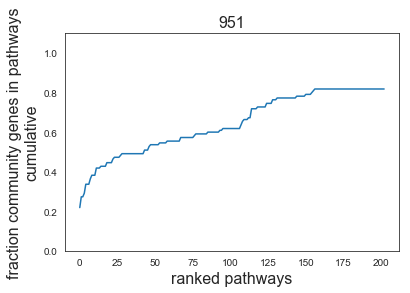

In [16]:
plt.plot(np.divide(cum_genes_captured,np.float(len(genes_in_cluster))))
plt.ylim([0,1.1])
plt.xlabel('ranked pathways',fontsize=16)
plt.ylabel('fraction community genes in pathways\ncumulative',fontsize=16)
plt.title(str(focal_cluster),fontsize=16)
print(np.setdiff1d(genes_in_cluster,genes_explained))

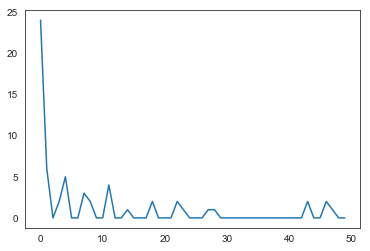

In [17]:
plt.plot(np.diff([0]+cum_genes_captured)[0:50])

<Figure size 432x288 with 0 Axes>

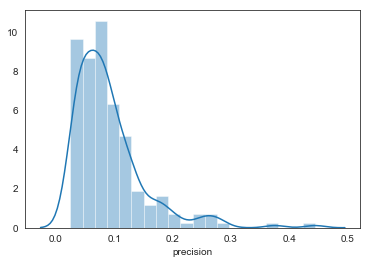

<Figure size 432x288 with 0 Axes>

In [18]:
sns.distplot(gprofiler_df['precision'])
plt.figure()
# sns.jointplot('precision','recall',data=gprofiler_df)

In [19]:
gprofiler_df.sort_values('precision',ascending=False).head()

,query.number,significant,p.value,term.size,query.size,overlap.size,recall,precision,term.id,domain,subgraph.number,term.name,relative.depth,intersection
296,1,True,0.000002,9,102,4,0.039,0.444,GO:0048096,BP,1,chromatin-mediated maintenance of transcription,1,"ARID1B,SMARCD1,ARID1A,CTNNB1"
709,1,True,0.000124,8,102,3,0.029,0.375,GO:0008091,CC,1,spectrin,1,"EPB41L2,SPTBN1,SPTAN1"
430,1,True,0.000015,14,102,4,0.039,0.286,GO:0071565,CC,1,nBAF complex,1,"ARID1B,SMARCD1,SMARCB1,ARID1A"
824,1,True,0.000317,11,102,3,0.029,0.273,GO:0060767,BP,1,epithelial cell proliferation involved in pros...,1,"SOX9,NOTCH1,CTNNB1"
823,1,True,0.000317,11,102,3,0.029,0.273,GO:1990907,CC,1,beta-catenin-TCF complex,1,"TCF7L2,CTNNB1,BCL9L"


In [22]:
sim_rank_EL = pd.read_csv('new_clixo_files/sim_rank_cosine_EL.tsv',sep='\t',names=['gene1','gene2','norm_cos_sim'])
sim_rank_EL.head()

,gene1,gene2,norm_cos_sim
0,SMARCC2,HIST1H4B,0.981613
1,SMARCC2,ZCCHC11,0.760676
2,SMARCC2,SMARCC1,1.000000
3,SMARCC2,ZDHHC12,0.212930
4,SMARCC2,HIST1H4J,0.983393


In [33]:
# reshape sim_rank edge list into adjacency matrix (takes a few minutes)
ASD_CHD_genes = gene2term.index.tolist()
gene_sim_df = pd.DataFrame(np.zeros((len(ASD_CHD_genes),len(ASD_CHD_genes))),index=ASD_CHD_genes)
gene_sim_df.columns=ASD_CHD_genes

for i in sim_rank_EL.index.tolist():
    if (i%5000)==0:
        print(i) # print out some progress
    focal_row=sim_rank_EL.loc[i]
    focal_gene1=focal_row['gene1']
    focal_gene2=focal_row['gene2']
    focal_norm_cos_sim = focal_row['norm_cos_sim']
    
    gene_sim_df.loc[focal_gene1][focal_gene2]=focal_norm_cos_sim
    gene_sim_df.loc[focal_gene2][focal_gene1]=focal_norm_cos_sim # symmetric
    
gene_sim_df.head()

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000
270000
275000
280000
285000
290000
295000
300000
305000
310000
315000
320000
325000
330000
335000
340000
345000
350000
355000


,AC008575.1,AC067968.1,ACHE,ACTB,ACTN2,ACTN4,ADAM17,ADGRL2,ADNP,AFDN,...,ZNF532,ZNF536,ZNF638,ZNF644,ZNF652,ZNF740,ZNF865,ZSWIM8,ZZEF1,ZZZ3
AC008575.1,0.000000,0.341637,0.310795,0.558719,0.247034,0.699585,0.770166,0.301601,0.589561,0.928529,...,0.251186,0.278470,0.236655,0.250297,0.252669,0.330664,0.448992,0.306643,0.261269,0.253262
AC067968.1,0.341637,0.000000,0.255042,0.494662,0.529359,0.185053,0.196323,0.245848,0.526690,0.201364,...,0.195433,0.980724,0.530842,0.484579,0.664887,0.274911,0.393238,0.250890,0.205516,0.731613
ACHE,0.310795,0.255042,0.000000,0.612100,0.874259,0.154211,0.637604,0.832740,0.403025,0.630486,...,0.434757,0.789146,0.314947,0.385824,0.514531,0.244069,0.362396,0.220047,0.571471,0.481613
ACTB,0.558719,0.494662,0.612100,0.000000,0.890273,0.988731,0.620700,0.341044,0.735469,0.629893,...,0.657770,0.491696,0.655397,0.513938,0.487544,0.338671,0.279656,0.499110,0.565243,0.613286
ACTN2,0.247034,0.529359,0.874259,0.890273,0.000000,0.994662,0.501186,0.902728,0.547450,0.424377,...,0.682384,0.838078,0.476868,0.295374,0.304864,0.180308,0.298636,0.409253,0.356465,0.545374


In [34]:
# load the pairwise gene similarity score
# gene_sim_df = pd.read_csv('new_clixo_files/sim_rank_cosine.tsv',sep='\t',index_col='Unnamed: 0')
# print(len(gene_sim_df))
# gene_sim_df.head()

In [550]:
# sns.clustermap(gene_sim_df)

In [35]:
len(genes_in_cluster)

110

/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


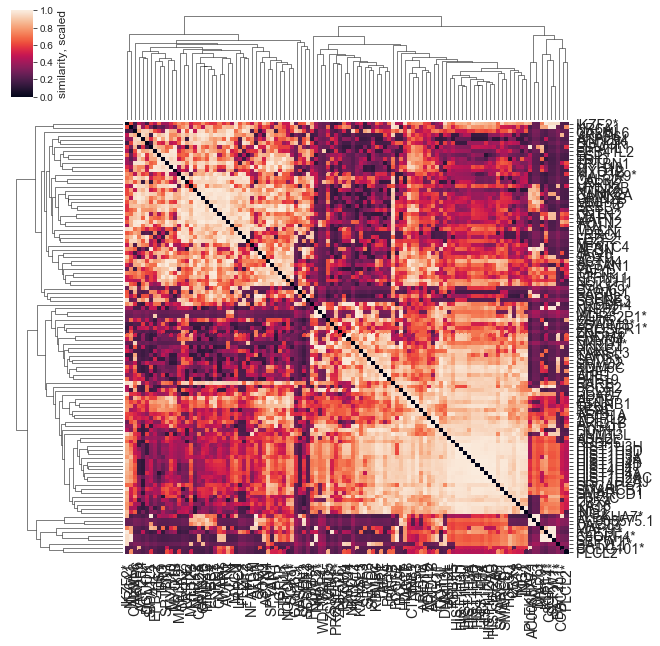

In [36]:
sim_plot_temp = gene_sim_df.loc[genes_in_cluster][genes_in_cluster]
# sim_plot_temp = sim_plot_temp*(sim_plot_temp>.9)

cfig = sns.clustermap(sim_plot_temp)
plt.ylabel('similarity, scaled',fontsize=12)
plt.sca(cfig.ax_heatmap)
new_ax_labels = [g if g in genes_explained else g+'*' for g in cfig.data2d.index.tolist()]
plt.xticks(np.arange(len(new_ax_labels))+.5,new_ax_labels,fontsize=14)
tmp=plt.yticks(np.arange(len(new_ax_labels))+.5,new_ax_labels,fontsize=14)
# plt.savefig('new_clixo_no_alignment/figures_COSINE_alpha01_beta45/gene_similarities_in_clusters/cluster_'+str(focal_cluster)+'.png',
#            dpi=300,bbox_inches='tight')

In [37]:
# look for which genes are not in any enrichment (these genes are the extensions of known pathways). 
# Can save and load to cytoscape for further annotation/analysis
extended_genes = pd.DataFrame({'extended_gene':np.ones(len(genes_in_cluster))},index=genes_in_cluster)
extended_genes.loc[genes_explained]=0
# extended_genes.to_csv('new_clixo_files/extended_genes/cluster_'+str(focal_cluster)+'_extended_genes.tsv',
#                       sep='\t')
extended_genes.head()

,extended_gene
AC008575.1,0.0
ACTB,0.0
ACTN2,0.0
ACTN4,0.0
AFDN,0.0


In [38]:
# print out the extended genes for a closer look
for g in extended_genes[extended_genes['extended_gene']==1].index.tolist():
    print(g)

BAT2L1
C7orf69
C8ORF4
CALB2
CCDC101
IKZF2
KLF11
MAP3K9
MAP9
MLL2
N4BP2
NKPD1
PLCL2
PLEKHA7
PROSER1
SEPW1
SGK1
WDR82P1
ZNF526
ZSWIM8


In [39]:
# keep only reactome pathways
gprofiler_df['domain'].value_counts()

BP     93
rea    63
CC     26
MF     18
keg     3
Name: domain, dtype: int64

# make a network out of the shared genes connecting each significantly enriched reactome pathway, cluster it

In [45]:
# make a network out of the shared genes connecting each significantly enriched reactome pathway, cluster it
t2list = []
t1list =[]
term_edgelist = []
gprofiler_df.index=gprofiler_df['term.name']
print(len(gprofiler_df))
# keep only reactome pathways
gprofiler_df = gprofiler_df[gprofiler_df['domain']=='rea']
# restrict to overlap.size > 10

# gprofiler_df = gprofiler_df[gprofiler_df['overlap.size']>10]
print(len(gprofiler_df))
# drop duplicate pathways (keep most significant one)
gprofiler_df = gprofiler_df.loc[~gprofiler_df.index.duplicated(keep='first')]
for i in np.arange(len(gprofiler_df)-1):
    if (i%10)==0:
        print(i)
    t1 = gprofiler_df.iloc[i]['term.name']
    genes1 = gprofiler_df.loc[t1]['intersection'].split(',')
    for j in np.arange(1+i,len(gprofiler_df)):

        t2 = gprofiler_df.iloc[j]['term.name']
        genes2 = gprofiler_df.loc[t2]['intersection'].split(',')
        
        jaccard_temp = len(np.intersect1d(genes1,genes2))/np.float(len(np.union1d(genes1,genes2)))
        t1list.append(t1)
        t2list.append(t2)
        term_edgelist.append(jaccard_temp)
        
        
term_edge_df = pd.DataFrame({'t1':t1list,'t2':t2list,'jaccard':term_edgelist})
term_edge_df.head()
        
        
    

63
63
0
10
20
30
40
50
60


,jaccard,t1,t2
0,1.000000,Chromatin modifying enzymes,Chromatin organization
1,0.444444,Chromatin modifying enzymes,Formation of the beta-catenin:TCF transactivat...
2,0.608696,Chromatin modifying enzymes,RMTs methylate histone arginines
3,0.565217,Chromatin modifying enzymes,PKMTs methylate histone lysines
4,0.615385,Chromatin modifying enzymes,Transcriptional regulation by RUNX1


In [46]:
# only keep edges with jaccard sim > 0.25
term_edge_filtered = term_edge_df[term_edge_df['jaccard']>.25]
print(len(term_edge_filtered))



1559


In [47]:
G_terms = nx.Graph()
G_terms.add_weighted_edges_from(zip(term_edge_filtered['t1'].tolist(),term_edge_filtered['t2'].tolist(),
                                   term_edge_filtered['jaccard'].tolist()))
print(len(G_terms.nodes()))
print(len(G_terms.edges()))

# how many CCs?
print(len(list(nx.connected_components(G_terms))))

62
1559
2


In [48]:
partition = pd.Series(community.best_partition(G_terms))
partition.value_counts()

1    33
2    13
0    13
3     3
dtype: int64

In [49]:
partition[partition==0].index.tolist()

[u'Activation of HOX genes during differentiation',
 u'Activation of anterior HOX genes in hindbrain development during early embryogenesis',
 u'Chromatin modifying enzymes',
 u'Chromatin organization',
 u'Deactivation of the beta-catenin transactivating complex',
 u'Formation of the beta-catenin:TCF transactivating complex',
 u'PKMTs methylate histone lysines',
 u'RMTs methylate histone arginines',
 u'RUNX1 interacts with co-factors whose precise effect on RUNX1 targets is not known',
 u'RUNX1 regulates genes involved in megakaryocyte differentiation and platelet function',
 u'Signaling by WNT',
 u'TCF dependent signaling in response to WNT',
 u'Transcriptional regulation by RUNX1']

In [50]:
import scipy

G_adj = scipy.sparse.csr_matrix.todense(nx.adjacency_matrix(G_terms))
G_adj=pd.DataFrame(G_adj)
G_adj.columns=G_terms.nodes()
G_adj.index=G_terms.nodes()
G_adj.head()

,Transcriptional regulation by RUNX1,Activation of HOX genes during differentiation,Negative epigenetic regulation of rRNA expression,Telomere Maintenance,ESR-mediated signaling,RNA Polymerase I Transcription,PRC2 methylates histones and DNA,RUNX1 regulates genes involved in megakaryocyte differentiation and platelet function,Chromatin modifying enzymes,DNA methylation,...,PKMTs methylate histone lysines,DNA Damage/Telomere Stress Induced Senescence,Epigenetic regulation of gene expression,HDMs demethylate histones,Meiosis,RHO GTPases activate PKNs,Senescence-Associated Secretory Phenotype (SASP),RNA Polymerase I Promoter Clearance,Chromatin organization,Cell-Cell communication
Transcriptional regulation by RUNX1,0.000000,0.545455,0.526316,0.315789,0.500000,0.526316,0.476190,0.631579,0.615385,0.500000,...,0.454545,0.300000,0.434783,0.400000,0.526316,0.476190,0.526316,0.526316,0.615385,0.0
Activation of HOX genes during differentiation,0.545455,0.000000,0.666667,0.400000,0.625000,0.666667,0.588235,0.800000,0.461538,0.625000,...,0.555556,0.375000,0.526316,0.500000,0.666667,0.588235,0.666667,0.666667,0.461538,0.0
Negative epigenetic regulation of rRNA expression,0.526316,0.666667,0.000000,0.600000,0.909091,1.000000,0.833333,0.833333,0.434783,0.909091,...,0.533333,0.545455,0.714286,0.727273,1.000000,0.833333,1.000000,1.000000,0.434783,0.0
Telomere Maintenance,0.315789,0.400000,0.600000,0.000000,0.545455,0.600000,0.500000,0.500000,0.260870,0.545455,...,0.266667,0.857143,0.428571,0.363636,0.600000,0.500000,0.600000,0.600000,0.260870,0.0
ESR-mediated signaling,0.500000,0.625000,0.909091,0.545455,0.000000,0.909091,0.769231,0.769231,0.416667,0.833333,...,0.500000,0.500000,0.666667,0.666667,0.909091,0.769231,0.909091,0.909091,0.416667,0.0


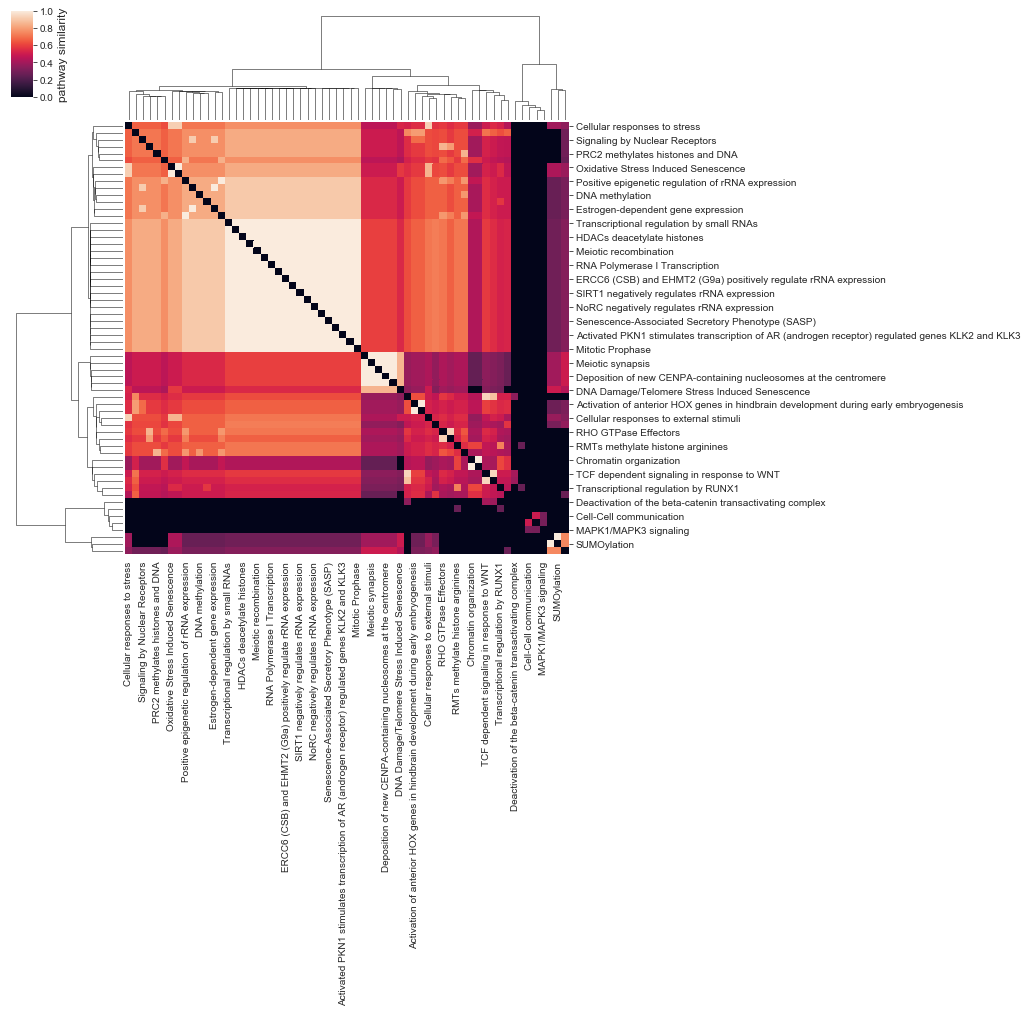

In [52]:
cfig = sns.clustermap(G_adj)
plt.ylabel('pathway similarity',fontsize=12)
plt.savefig('new_clixo_files/figures/gene_similarities_in_clusters/reactome_pathway_similarity_heatmap_'+str(focal_cluster)+'.png',dpi=300,bbox_inches='tight')

# Load STRING with edge types, to annotate cosine sim edges with prior knowledge (for Supp figure 8)

Download string database, homo sapiens https://string-db.org/cgi/download.pl?sessionId=VIqQ9nJx59dR

# SKIP THIS BLOCK AFTER THE FIRST TIME THROUGH

In [53]:
string_df = pd.read_csv('/Users/brinrosenthal/Documents/CCBB_tickets_data/STRING/human/9606.protein.links.detailed.v11.0.txt.gz',
                       delim_whitespace=True)
string_df.head()

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
0,9606.ENSP00000000233,9606.ENSP00000272298,0,0,332,62,181,0,125,490
1,9606.ENSP00000000233,9606.ENSP00000253401,0,0,0,0,186,0,56,198
2,9606.ENSP00000000233,9606.ENSP00000401445,0,0,0,0,159,0,0,159
3,9606.ENSP00000000233,9606.ENSP00000418915,0,0,0,61,158,0,542,606
4,9606.ENSP00000000233,9606.ENSP00000327801,0,0,0,88,78,0,89,167


In [54]:
# load STRING gene mapping
string_mapping = pd.read_csv('/Users/brinrosenthal/Documents/CCBB_tickets_data/STRING/human/human.name_2_string.tsv',sep='\t',
                            skiprows=1,names=['gene_name','string_ID'])
print(len(string_mapping))
string_mapping.index=string_mapping['string_ID']
string_mapping.head()

19095


,gene_name,string_ID
string_ID,,
9606.ENSP00000395733,ZNF737,9606.ENSP00000395733
9606.ENSP00000460380,USP6,9606.ENSP00000460380
9606.ENSP00000306894,ETV5,9606.ENSP00000306894
9606.ENSP00000325589,PTPRCAP,9606.ENSP00000325589
9606.ENSP00000287020,GDF6,9606.ENSP00000287020


In [55]:
string_df['gene_name1']=string_df['protein1'].map(dict(string_mapping['gene_name']))
string_df['gene_name2']=string_df['protein2'].map(dict(string_mapping['gene_name']))
print(len(string_df))
string_df = string_df.dropna()
print(len(string_df))
# need to reindex after dropna()
string_df.index=list(np.arange(len(string_df)))
string_df.tail()

11759454
11511400


,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene_name1,gene_name2
11511395,9606.ENSP00000485678,9606.ENSP00000310488,0,0,0,167,0,0,0,167,OR6Q1,OR7D4
11511396,9606.ENSP00000485678,9606.ENSP00000342448,0,0,0,175,0,0,0,175,OR6Q1,OR5W2
11511397,9606.ENSP00000485678,9606.ENSP00000350222,0,0,0,195,0,0,0,195,OR6Q1,OR51D1
11511398,9606.ENSP00000485678,9606.ENSP00000367590,0,0,0,0,0,900,0,900,OR6Q1,REEP2
11511399,9606.ENSP00000485678,9606.ENSP00000349930,0,0,0,213,0,0,0,213,OR6Q1,OR11G2


In [6]:
# filter STRING by PCNet edges.... instead of using a cutoff.  Only keep edges which are in PCnet
G_PCnet = nx.read_gpickle(path_to_PCnet)
print(len(G_PCnet.nodes()))
print(len(G_PCnet.edges()))

19781
2724724


In [58]:
index_keep = []

import time
n1list_temp=string_df['gene_name1'].tolist()
n2list_temp=string_df['gene_name2'].tolist()
t0=time.time()
for i in np.arange(len(n2list_temp)):
    if (i%100000)==0:
        print(i)
        print(time.time()-t0)
        t0=time.time()
    n1=n1list_temp[i]
    n2=n2list_temp[i]
    
    if G_PCnet.has_edge(n1,n2): # not directional: n1,n2 equivalent to n2,n1
        index_keep.append(i)
print(len(index_keep))

                   

0
0.0101561546326
100000
0.158532857895
200000
0.156804084778
300000
0.161190986633
400000
0.159049034119
500000
0.157835006714
600000
0.157951116562
700000
0.172850847244
800000
0.173509120941
900000
0.160359144211
1000000
0.169507980347
1100000
0.16649889946
1200000
0.161399841309
1300000
0.157567024231
1400000
0.15758895874
1500000
0.162763834
1600000
0.163357973099
1700000
0.163990020752
1800000
0.162431955338
1900000
0.1625020504
2000000
0.160284042358
2100000
0.172600030899
2200000
0.156625986099
2300000
0.159898996353
2400000
0.161360025406
2500000
0.219348907471
2600000
0.191222906113
2700000
0.182564020157
2800000
0.164085865021
2900000
0.160661935806
3000000
0.16037607193
3100000
0.157541036606
3200000
0.157332897186
3300000
0.160933017731
3400000
0.154322862625
3500000
0.157344818115
3600000
0.158337116241
3700000
0.133538007736
3800000
0.137755870819
3900000
0.158153772354
4000000
0.157862186432
4100000
0.15918803215
4200000
0.160732984543
4300000
0.157027959824
4400000
0.1

In [59]:
# filter by index_keep
print(len(string_df))
string_df = string_df.loc[index_keep]
print(len(string_df))


11511400
2320270


In [60]:
# make a multigraph out of STRING edge types
G_str_MG = nx.MultiGraph() 
G_str_MG

In [61]:
database_edges = string_df[string_df['database']>0]
database_edges = zip(database_edges['gene_name1'].tolist(),database_edges['gene_name2'].tolist(),database_edges['database'].tolist())
print(len(database_edges))
print(database_edges[0:5])

coexpression_edges = string_df[string_df['coexpression']>0]
coexpression_edges = zip(coexpression_edges['gene_name1'].tolist(),coexpression_edges['gene_name2'].tolist(),coexpression_edges['coexpression'].tolist())
print(len(coexpression_edges))
print(coexpression_edges[0:5])

experimental_edges = string_df[string_df['experimental']>0]
experimental_edges = zip(experimental_edges['gene_name1'].tolist(),experimental_edges['gene_name2'].tolist(),experimental_edges['experimental'].tolist())
print(len(experimental_edges))
print(experimental_edges[0:5])

textmining_edges = string_df[string_df['textmining']>0]
textmining_edges = zip(textmining_edges['gene_name1'].tolist(),textmining_edges['gene_name2'].tolist(),textmining_edges['textmining'].tolist())
print(len(textmining_edges))
print(textmining_edges[0:5])

other_edges = string_df[string_df[['neighborhood','fusion','cooccurence']].T.sum()>0]
other_edges = zip(other_edges['gene_name1'].tolist(),other_edges['gene_name2'].tolist(),other_edges[['neighborhood','fusion','cooccurence']].T.max().tolist())
print(len(other_edges))
print(other_edges[0:5])

515840
[('ARF5', 'SPTBN2', 900), ('ARF5', 'TMED7', 900), ('ARF5', 'ARFGAP1', 900), ('ARF5', 'ANK2', 900), ('ARF5', 'KDELR2', 900)]
1613500
[('ARF5', 'P4HB', 88), ('ARF5', 'STX10', 141), ('ARF5', 'GART', 61), ('ARF5', 'SGSM3', 64), ('ARF5', 'SPTBN2', 62)]
1039116
[('ARF5', 'P4HB', 78), ('ARF5', 'STX10', 131), ('ARF5', 'SGSM3', 130), ('ARF5', 'SPTBN2', 63), ('ARF5', 'AP1B1', 706)]
1815558
[('ARF5', 'P4HB', 89), ('ARF5', 'STX10', 98), ('ARF5', 'GART', 224), ('ARF5', 'SGSM3', 48), ('ARF5', 'SPTBN2', 94)]
141412
[('ARF5', 'PPP4C', 252), ('ARF5', 'PPP1CA', 373), ('ARF5', 'LRRK2', 44), ('ARF5', 'ARL4C', 54), ('ARF5', 'ARF1', 49)]


In [62]:
G_str_MG.add_weighted_edges_from(database_edges,label='STRING_database')
print(len(G_str_MG.nodes()))
print(len(G_str_MG.edges()))

G_str_MG.add_weighted_edges_from(coexpression_edges,label='STRING_coexpression')
print(len(G_str_MG.nodes()))
print(len(G_str_MG.edges()))

G_str_MG.add_weighted_edges_from(experimental_edges,label='STRING_experimental')
print(len(G_str_MG.nodes()))
print(len(G_str_MG.edges()))

G_str_MG.add_weighted_edges_from(textmining_edges,label='STRING_textmining')
print(len(G_str_MG.nodes()))
print(len(G_str_MG.edges()))
G_str_MG.edges(data=True)[0:5]

G_str_MG.add_weighted_edges_from(other_edges,label='STRING_other')
print(len(G_str_MG.nodes()))
print(len(G_str_MG.edges()))
G_str_MG.edges(data=True)[0:5]

10622
515840
17104
2129340
17829
3168456
18055
4984014
18055
5125426


[('UBE2Q1', 'TRIM11', {'label': 'STRING_database', 'weight': 900}),
 ('UBE2Q1', 'TRIM11', {'label': 'STRING_database', 'weight': 900}),
 ('UBE2Q1', 'HECTD3', {'label': 'STRING_database', 'weight': 900}),
 ('UBE2Q1', 'HECTD3', {'label': 'STRING_database', 'weight': 900}),
 ('UBE2Q1', 'HECTD3', {'label': 'STRING_textmining', 'weight': 55})]

In [19]:
'ABCC2' in G_str.nodes()

True

# Create a subgraph containing edge data from string and PCnet where no string data available

# RESTART HERE AFTER THE FIRST TIME THROUGH

In [63]:
# ADD PCNET EDGES WHICH AREN'T IN STRING, AS PCNET_OTHER
G_PCnet_focal=nx.subgraph(G_PCnet,genes_in_cluster)
G_PCnet_focal
print(len(G_PCnet_focal.nodes()))
print(len(G_PCnet_focal.edges()))

# needs to be a multigraph for diff to work
G_PCnet_multi=nx.MultiGraph()
G_PCnet_multi.add_nodes_from(genes_in_cluster)
G_PCnet_multi.add_edges_from(G_PCnet_focal.edges())
print(len(G_PCnet_multi.nodes()))
print(len(G_PCnet_multi.edges()))

G_str_focal = nx.subgraph(G_str_MG,genes_in_cluster)
print(len(G_str_focal.nodes()))
print(len(G_str_focal.edges()))

# make sure they have the same nodes
nodes_add=list(np.setdiff1d(genes_in_cluster,G_str_focal.nodes()))
G_str_focal.add_nodes_from(nodes_add)
print(len(G_str_focal.nodes()))
print(len(G_str_focal.edges()))

# find the edges in pcnet, not in string
G_diff = nx.difference(G_PCnet_multi,G_str_focal)
print(len(G_diff.nodes()))
print(len(G_diff.edges()))

G_str_focal.add_edges_from(G_diff.edges(),label='PCnet_other')
print(len(G_str_focal.nodes()))
print(len(G_str_focal.edges()))

110
657
110
657
103
2616
110
2616
110
157
110
2773


In [64]:

G_str_focal.edges(data=True)[0:10]

[('HIST1H4B', 'HIST1H4A', {'label': 'STRING_database', 'weight': 900}),
 ('HIST1H4B', 'HIST1H4A', {'label': 'STRING_database', 'weight': 900}),
 ('HIST1H4B', 'HIST1H4A', {'label': 'STRING_coexpression', 'weight': 480}),
 ('HIST1H4B', 'HIST1H4A', {'label': 'STRING_coexpression', 'weight': 480}),
 ('HIST1H4B', 'HIST1H4A', {'label': 'STRING_experimental', 'weight': 800}),
 ('HIST1H4B', 'HIST1H4A', {'label': 'STRING_experimental', 'weight': 800}),
 ('HIST1H4B', 'HIST1H4A', {'label': 'STRING_textmining', 'weight': 47}),
 ('HIST1H4B', 'HIST1H4A', {'label': 'STRING_textmining', 'weight': 47}),
 ('HIST1H4B', 'HIST1H3D', {'label': 'STRING_database', 'weight': 900}),
 ('HIST1H4B', 'HIST1H3D', {'label': 'STRING_database', 'weight': 900})]

In [65]:
n1list,n2list,wlist,ETlist=[],[],[],[]
for e in G_str_focal.edges(data=True):
    n1list.append(e[0])
    n2list.append(e[1])
    if 'weight' in e[2].keys():
        wlist.append(e[2]['weight'])
    else:
        wlist.append(1)
    ETlist.append(e[2]['label'])
    
G_str_focal_df = pd.DataFrame({'node1':n1list,'node2':n2list,'weight':wlist,'edge_type':ETlist})
print(len(G_str_focal))
G_str_focal_df.head()

110


,edge_type,node1,node2,weight
0,STRING_database,HIST1H4B,HIST1H4A,900
1,STRING_database,HIST1H4B,HIST1H4A,900
2,STRING_coexpression,HIST1H4B,HIST1H4A,480
3,STRING_coexpression,HIST1H4B,HIST1H4A,480
4,STRING_experimental,HIST1H4B,HIST1H4A,800


In [66]:
G_str_focal_df['edge_type'].value_counts()

STRING_textmining      940
STRING_experimental    780
STRING_coexpression    548
STRING_database        258
PCnet_other            157
STRING_other            90
Name: edge_type, dtype: int64

In [67]:
# find the indices of unique edges


new_n1,new_n2=[],[]
# require edge list to be alphabetical
for i in G_str_focal_df.index.tolist():
    n1 = G_str_focal_df.loc[i]['node1']
    n2 = G_str_focal_df.loc[i]['node2']
    
    if n2<n1: # swap if not alphabetical
        new_n1.append(n2)
        new_n2.append(n1)
    else:
        new_n1.append(n1)
        new_n2.append(n2)
        
G_str_focal_df['node1']=new_n1
G_str_focal_df['node2']=new_n2
        
    
# reindex, and drop dups
G_str_focal_df.index=[str(e) for e in zip(G_str_focal_df['node1'],G_str_focal_df['node2'],G_str_focal_df['edge_type'])]
# drop duplicate indices
print(len(G_str_focal_df))
G_str_focal_df = G_str_focal_df.loc[~G_str_focal_df.index.duplicated(keep='first')]
print(len(G_str_focal_df))
G_str_focal_df.head()




2773
1465


,edge_type,node1,node2,weight
"('HIST1H4A', 'HIST1H4B', 'STRING_database')",STRING_database,HIST1H4A,HIST1H4B,900
"('HIST1H4A', 'HIST1H4B', 'STRING_coexpression')",STRING_coexpression,HIST1H4A,HIST1H4B,480
"('HIST1H4A', 'HIST1H4B', 'STRING_experimental')",STRING_experimental,HIST1H4A,HIST1H4B,800
"('HIST1H4A', 'HIST1H4B', 'STRING_textmining')",STRING_textmining,HIST1H4A,HIST1H4B,47
"('HIST1H3D', 'HIST1H4B', 'STRING_database')",STRING_database,HIST1H3D,HIST1H4B,900


In [68]:
# write out network for cytoscape visualization
# G_str_focal_df.to_csv('new_clixo_files/clixo_subgraphs_with_edgedata/STRING_cluster_'+str(focal_cluster)+'.tsv',sep='\t')
